<a href="https://colab.research.google.com/github/gustavor10silva/IC-Redes-Neurais-Artificiais/blob/main/transfer_learning_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas a serem usadas

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from functools import partial
%matplotlib inline

# Baixando o dataset MNIST e estruturando os dados de treino, validação e teste

In [2]:
# baixando os dados do dataset MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [16]:
# dividindo dados de treino
X1 = X_train_full[y_train_full <= 4]
y1 = y_train_full[y_train_full <= 4]
X2 = X_train_full[y_train_full > 4]
y2 = y_train_full[y_train_full > 4]

# dividindo dados de teste
X1_test = X_test[y_test <= 4]
y1_test = y_test[y_test <= 4]
X2_test = X_test[y_test > 4]
y2_test = y_test[y_test > 4]

In [17]:
# escalando e dividindo o treino entre treino e validação (0 a 4)
X1_valid, X1_train = X1[:25000]/255.0, X1[25000:]/255.0
y1_valid, y1_train = y1[:25000], y1[25000:]
X1_test_scaled = X1_test/255.0

# escalando e dividindo o treino entre treino e validação (5 a 9)
X2_valid, X2_train = X2[:25000]/255.0, X2[25000:]/255.0
y2_valid, y2_train = y2[:25000], y2[25000:]
X2_test_scaled = X2_test/255.0

# Separando apenas 100 imagens por dígito (de 5 a 9) para o treinamento, totalizando 500 imagens

In [151]:
# separando 100 imagens de cada dígito
X_digito5 = X2_train[y2_train == 5][0:100]
X_digito6 = X2_train[y2_train == 6][0:100]
X_digito7 = X2_train[y2_train == 7][0:100]
X_digito8 = X2_train[y2_train == 8][0:100]
X_digito9 = X2_train[y2_train == 9][0:100]

# separando 100 rótulos de cada dígito
y_digito5 = [5]*100
y_digito6 = [6]*100
y_digito7 = [7]*100
y_digito8 = [8]*100
y_digito9 = [9]*100

In [163]:
# concatenando os vetores de imagem
X_train_full_small = np.concatenate([X_digito5, X_digito6, X_digito7, X_digito8, X_digito9])
len(X_train_full_small)

500

In [185]:
# concatenando os vetores de rótulos
y_train_full_small = np.concatenate([y_digito5, y_digito6, y_digito7, y_digito8, y_digito9])
len(y_train_full_small)

500

In [188]:
# dividindo os dados entre treino e validação com o train_test_split
X_train_small, X_valid_small, y_train_small, y_valid_small = train_test_split(X_train_full_small, y_train_full_small, test_size=0.30, random_state=42)

In [189]:
len(y_train_small), len(y_valid_small)

(350, 150)

5


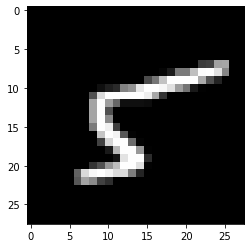

6


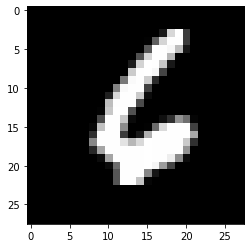

5


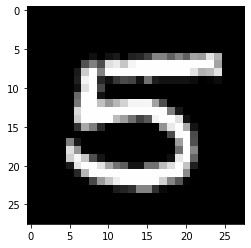

In [190]:
# verificando se os rótulos do treino correspondem às imagens do treino
for i in range(3):
  fig = plt.figure
  plt.imshow(X_train_small[i], cmap='gray')
  print(y_train_small[i])
  plt.show()

8


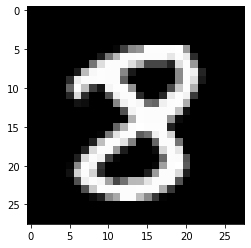

5


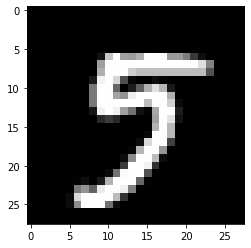

8


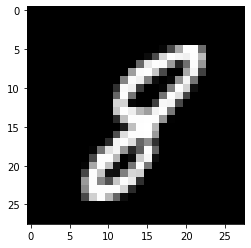

In [191]:
# verificando se os rótulos da validação correspondem às imagens da validação
for i in range(3):
  fig = plt.figure
  plt.imshow(X_valid_small[i], cmap='gray')
  print(y_valid_small[i])
  plt.show()

# Treinando e avaliando um modelo usando somente as 500 imagens disponíveis

In [234]:
# "hidden" será o nome da camada densa, que estamos definindo com a função de ativação "elu" e o inicializador "he_normal"
hidden = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal")

# o modelo será sequencial, com 5 camadas escondidas e cada uma delas com 100 neurônios
modelo = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]), # o formato de entrada é 28x28 porque as imagens de entrada possuem 28 pixels de largura e de altura
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(5, activation="softmax") # a camada de saída, com a função de ativação softmax, possui 5 neurônios porque existem 5 rótulos possíveis na classificação: os dígitos de 5 a 9
])
optimizer = keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999) # o otimizador a ser usado é o Adam
modelo.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) # compilando o modelo com loss="sparse_categorical_crossentropy" e a métrica de acurácia

In [ ]:
# vamos treinar o modelo. Note que permitimos 1000 épocas de treino usando o callback EarlyStopping com paciência 10
# isso significa que se o treino tiver 10 épocas sem melhoria no loss da validação, o treinamento será interrompido
history_modelo = modelo.fit(X_train_small, y_train_small - 5, epochs=1000, validation_data=(X_valid_small, y_valid_small - 5), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

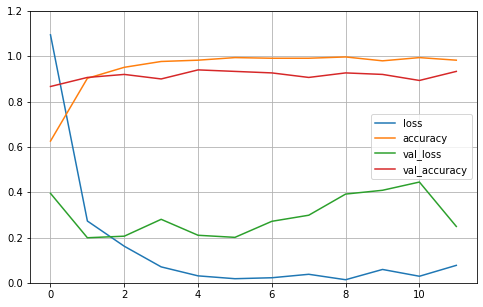

In [236]:
# vamos plotar as informações de loss e acurácia do treinamento
pd.DataFrame(history_modelo.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # o alcance vertical será de 0 a 1.2
plt.show()

In [237]:
# agora, avaliando o modelo no conjunto de teste, obtemos loss=0.4124276041984558 e acurácia=0.8998148441314697
modelo.evaluate(X2_test_scaled, y2_test - 5)

152/152 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8998


[0.4124276041984558, 0.8998148441314697]

# Agora, vamos treinar uma rede nos dígitos de 0 a 4, porque temos muitos dados rotulados dos dígitos de 0 a 4. Depois, vamos usar partes dessa rede para construir uma nova rede, que classificará os dígitos de 5 a 9

In [54]:
# criando o modelo "model8"
hidden = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal")

model8 = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(100),
 hidden(5, activation="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999)
model8.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# treinando o model8 nos dígitos de 0 a 4
history8 = model8.fit(X1_train, y1_train, epochs=200, validation_data=(X1_valid, y1_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

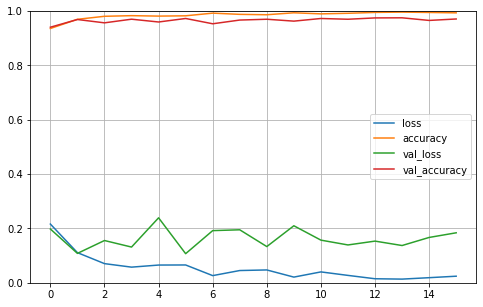

In [56]:
pd.DataFrame(history8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [57]:
# avaliando o model8 no conjunto de teste dos dígitos de 0 a 4
model8.evaluate(X1_test_scaled, y1_test)

161/161 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.9792


[0.14247994124889374, 0.9791788458824158]

In [58]:
# salvando o modelo para usá-lo depois
model8.save("model8.h5")

# Carregando a rede salva e transferindo o aprendizado

In [67]:
# carregando o modelo salvo e chamando-o de "model_A"
model_A = keras.models.load_model("model8.h5")

# clonando e compilando o modelo clonado para ter uma cópia salva
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
optimizer = keras.optimizers.Adam(learning_rate=0.003, beta_1=0.7, beta_2=0.999)
model_A_clone.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [68]:
# o comando .summary() mostra a estrutura da rede
model_A.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 5)               

In [246]:
# construindo o modelo novo e congelando as camadas escondidas
model_B = keras.models.Sequential(model_A.layers[:-1])
model_B.add(keras.layers.Dense(5, activation="softmax"))
for layer in model_B.layers[:-1]:
  layer.trainable = False

In [247]:
# compilando o modelo
optimizer = keras.optimizers.Adam(learning_rate=0.003, beta_1=0.7, beta_2=0.999)
model_B.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [248]:
model_B.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_102 (Dense)            (None, 5)               

In [249]:
# treinando o modelo por 4 épocas com as camadas escondidas congeladas, para melhorar um pouco os pesos da camada de saída, que foram inicializados aleatoriamente
history_B = model_B.fit(X_train_small, y_train_small - 5, epochs=4, validation_data=(X_valid_small, y_valid_small - 5))

Epoch 1/4
11/11 [==============================] - 2s 164ms/step - loss: 4.3392 - accuracy: 0.4943 - val_loss: 0.2898 - val_accuracy: 0.9133
Epoch 2/4
11/11 [==============================] - 0s 5ms/step - loss: 0.1099 - accuracy: 0.9514 - val_loss: 0.0529 - val_accuracy: 0.9867
Epoch 3/4
11/11 [==============================] - 0s 4ms/step - loss: 0.0377 - accuracy: 0.9829 - val_loss: 0.0277 - val_accuracy: 0.9867
Epoch 4/4
11/11 [==============================] - 0s 4ms/step - loss: 0.0218 - accuracy: 0.9857 - val_loss: 0.0178 - val_accuracy: 0.9933


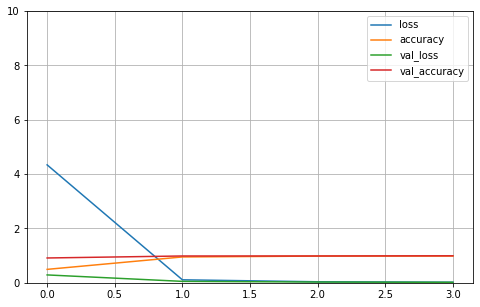

In [250]:
pd.DataFrame(history_B.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10) # set the vertical range to [0-1]
plt.show()

In [251]:
model_B.evaluate(X2_test_scaled, y2_test - 5)

152/152 [==============================] - 0s 2ms/step - loss: 0.2338 - accuracy: 0.9578


[0.23377758264541626, 0.957827627658844]

In [252]:
# agora, vamos descongelar as camadas escondidas, compilar o modelo novamente e treiná-lo o suficiente, para que todos os pesos se ajustem aos novos dados
for layer in model_B.layers[:-1]:
  layer.trainable = True
# compilando o modelo novamente com a taxa de aprendizagem reduzida. Note que learning_rate=0.0003
optimizer = keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.7, beta_2=0.999)
model_B.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_B = model_B.fit(X_train_small, y_train_small - 5, epochs=1000, validation_data=(X_valid_small, y_valid_small - 5), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

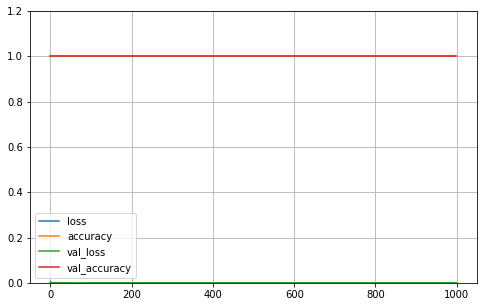

In [255]:
pd.DataFrame(history_B.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # set the vertical range to [0-1]
plt.show()

In [256]:
# perceba que obtemos um resultado melhor
model_B.evaluate(X2_test_scaled, y2_test - 5)

152/152 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.9702


[0.29008254408836365, 0.9701707363128662]

# Comparando os resultados

In [259]:
# veja a diferença entre o loss e a acurácia, respectivamente, de cada modelo
# ao usar a rede pré-treinada o loss diminuiu e o percentual de acerto subiu em pouco mais de 7%, o que é muito bom!
modelo.evaluate(X2_test_scaled, y2_test-5), model_B.evaluate(X2_test_scaled, y2_test-5)

152/152 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.9702


([0.4124276041984558, 0.8998148441314697],
 [0.29008254408836365, 0.9701707363128662])

# Podemos fazer previsões com os modelos

In [304]:
a = np.around(modelo.predict(X2_test_scaled[:20]))
for i in range(len(a)):
  pred = np.dot(np.array([5.0, 6.0, 7.0, 8.0, 9.0]), a[i])
  print('índice: ', i, 'predição: ', pred, 'rótulo: ', y2_test[i], pred == y2_test[i])

índice:  0 predição:  7.0 rótulo:  7 True
índice:  1 predição:  9.0 rótulo:  9 True
índice:  2 predição:  5.0 rótulo:  5 True
índice:  3 predição:  9.0 rótulo:  9 True
índice:  4 predição:  6.0 rótulo:  6 True
índice:  5 predição:  9.0 rótulo:  9 True
índice:  6 predição:  5.0 rótulo:  5 True
índice:  7 predição:  9.0 rótulo:  9 True
índice:  8 predição:  7.0 rótulo:  7 True
índice:  9 predição:  9.0 rótulo:  9 True
índice:  10 predição:  6.0 rótulo:  6 True
índice:  11 predição:  6.0 rótulo:  6 True
índice:  12 predição:  5.0 rótulo:  5 True
índice:  13 predição:  7.0 rótulo:  7 True
índice:  14 predição:  7.0 rótulo:  7 True
índice:  15 predição:  7.0 rótulo:  7 True
índice:  16 predição:  7.0 rótulo:  7 True
índice:  17 predição:  8.0 rótulo:  5 False
índice:  18 predição:  6.0 rótulo:  6 True
índice:  19 predição:  5.0 rótulo:  5 True


In [305]:
b = np.around(model_B.predict(X2_test_scaled[:20]))
for i in range(len(b)):
  pred = np.dot(np.array([5.0, 6.0, 7.0, 8.0, 9.0]), b[i])
  print('índice: ', i, 'predição: ', pred, 'rótulo: ', y2_test[i], pred == y2_test[i])

índice:  0 predição:  7.0 rótulo:  7 True
índice:  1 predição:  9.0 rótulo:  9 True
índice:  2 predição:  9.0 rótulo:  5 False
índice:  3 predição:  9.0 rótulo:  9 True
índice:  4 predição:  6.0 rótulo:  6 True
índice:  5 predição:  9.0 rótulo:  9 True
índice:  6 predição:  5.0 rótulo:  5 True
índice:  7 predição:  9.0 rótulo:  9 True
índice:  8 predição:  7.0 rótulo:  7 True
índice:  9 predição:  9.0 rótulo:  9 True
índice:  10 predição:  6.0 rótulo:  6 True
índice:  11 predição:  6.0 rótulo:  6 True
índice:  12 predição:  5.0 rótulo:  5 True
índice:  13 predição:  7.0 rótulo:  7 True
índice:  14 predição:  7.0 rótulo:  7 True
índice:  15 predição:  7.0 rótulo:  7 True
índice:  16 predição:  7.0 rótulo:  7 True
índice:  17 predição:  5.0 rótulo:  5 True
índice:  18 predição:  6.0 rótulo:  6 True
índice:  19 predição:  5.0 rótulo:  5 True


5


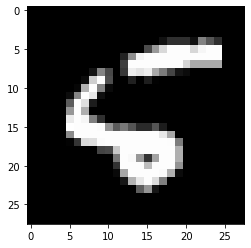

5


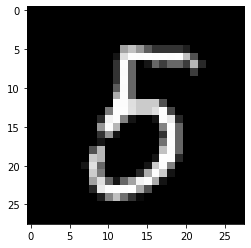

In [303]:
# vamos ver onde os modelos erraram?
for i in [2,17]:
  fig = plt.figure
  plt.imshow(X2_test_scaled[i], cmap='gray')
  print(y2_test[i])
  plt.show()